# Advection algorithms -- animation options

Illustrate solution of the advection equation $q_t + uq_x = 0$ where $u$ is constant.
Shows the upwind method on a square pulse.  

This version of [Advection_Examples3.ipynb](Advection_Examples3.ipynb) has two bugs fixed:
 - The time stepping loop should go over `range(1,nsteps+1) = [1, 2, ..., nsteps]` rather than `range(nsteps) = [0, 1, ..., nsteps-1]`.  This matters only because the time `tn = n*dt` is used to evaluate the true solution, which was off by `dt` in the original version.
 - The calling sequence of `upwind` has been changed to input `dt` and then `udtdx` can be computed locally.

This code is adapted from [Advection_Examples2.ipynb](Advection_Examples2.ipynb) and used to show how the `clawpack.visclaw.animation_tools` can be used to animate figures.  See [animation_tools_demo.ipynb](https://nbviewer.jupyter.org/url/www.clawpack.org/_static/notebooks/animation_tools_demo.ipynb) for some more examples. (But many of the animations don't show up when viewing this static version, so you should run the notebook  instead, which is found in the Clawpack applications repository, in `$CLAW/apps/notebooks/visclaw`.)

Figures are plotted during the time stepping and accumulated.  They can then be viewed as an animation using [ipywidgets](https://github.com/ipython/ipywidgets).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function

Import the `animation_tools` module.  This requires version 5.4.0 of Clawpack:

In [3]:
from clawpack.visclaw import animation_tools

Some other Jupyter tools:

In [4]:
from IPython.display import display, FileLink

## Desired true solution

Define the true solution as a function of $(x,t)$.  It will depend on the advection velocity `u`.  
Note how the periodic boundary conditions are imposed.

Evaluating this function at $t=0$ will give the initial conditions below.

In [5]:
def qtrue(x,t,u):
    x0 = x - u*t   # trace back characteristic to time 0
    x0 = mod(x0, 1.)  # use periodic boundary conditions to map to [0,1]
    q = where(abs(x0-0.2) < 0.1,  3., 2.)   # piecewise constant with values 2 and 3
    return q

### Define function to test one case

This function also make a plot every `nplot` time steps and accumulate these in `figs`, which is returned from the function call.

In [6]:
def upwind(x,tfinal,nsteps,u,dt,qtrue,nplot):
    
    dx = x[1] - x[0]  # assumes uniform grid
    udtdx = u*dt/dx

    # set initial data:
    q0 = qtrue(x,0.,u)

    # plot initial data:
    fig = figure()
    xfine = linspace(0,1,5000)   # fine grid for plotting true solution
    plot(xfine, qtrue(xfine,0.,u),'r-')
    title('Initial data')
    plot(x,q0,'bo')
    ylim(1,4)

    # Start accumulating figures
    # Will add more figures during time stepping
    figs = [fig]  
    close(fig)  # so it won't appear yet


    # extend to include 2 ghost cells on each side:
    qn_ext = hstack([0., 0., q0, 0., 0.])
    i1 = 2  # index of first interior cell
    imx = mx+1  # index of last interior cell

    for n in range(1, nsteps+1):

        # fill ghost cells for periodic BCs:
        qn_ext[i1-2] = qn_ext[imx-1]
        qn_ext[i1-1] = qn_ext[imx]
        qn_ext[imx+1] = qn_ext[i1]
        qn_ext[imx+2] = qn_ext[i1+1]

        qnp_ext = qn_ext.copy()  # make a copy, not a new pointer to old array

        for i in range(i1,imx+1):
            if u > 0:
                qnp_ext[i] = qn_ext[i] - udtdx * (qn_ext[i]-qn_ext[i-1])
            else:
                qnp_ext[i] = qn_ext[i] - udtdx * (qn_ext[i+1]-qn_ext[i])

        qn_ext = qnp_ext

        if mod(n,nplot) == 0:
            fig = figure()
            qn = qn_ext[i1:imx+1]
            plot(x,qn,'bo-')
            ylim(1,4)
            tn = n*dt
            plot(xfine, qtrue(xfine,tn,u),'r-')
            title('Time t = %g' % tfinal)
            figs.append(fig)
            close(fig)

    print("Took %i time steps and produced %i figures" % (nsteps,len(figs)))
    return figs

In [7]:
xlower = 0.
xupper = 1.
mx = 50
dx = float(xupper-xlower)/mx

# finite volume cell centers:
x = linspace(xlower+0.5*dx, xupper-0.5*dx, mx)
u = 1.

tfinal = 2.0
nsteps = 150
dt = float(tfinal)/nsteps
udtdx = u*dt/dx
cfl = abs(udtdx)
print("dx = %6.4f, dt = %6.4f, Courant number is cfl = %5.2f" % (dx,dt,cfl))

# Run the upwind method, which returns the set of figures, 
# plotting every nplot steps:
nplot = 2
figs = upwind(x,tfinal,nsteps,u,dt,qtrue,nplot)

dx = 0.0200, dt = 0.0133, Courant number is cfl =  0.67
Took 150 time steps and produced 76 figures


### View the final figure returned:

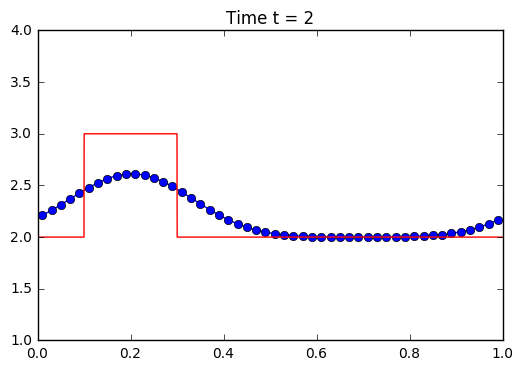

In [8]:
display(figs[-1])  # index -1 gives last element of array

### Make an animation using a widget:

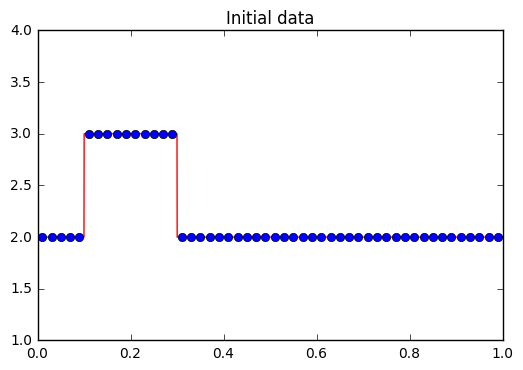

In [9]:
animation_tools.interact_animate_figs(figs)

You can convert the figures into a list of images:

In [10]:
images = animation_tools.make_images(figs)

View the last image:

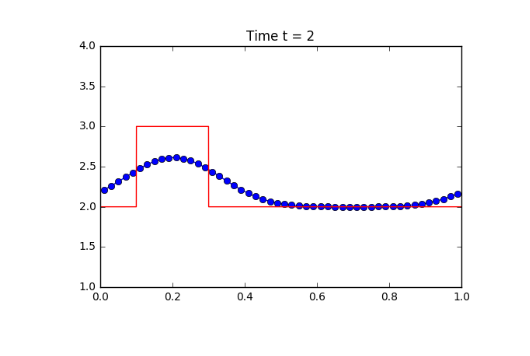

In [11]:
imshow(images[-1])
axis('off');  # or it adds a second axis

These can now be animated using [JSAnimation](https://github.com/jakevdp/JSAnimation):

In [12]:
anim = animation_tools.JSAnimate_images(images, figsize=(5,4));
display(anim)  # to display it in the notebook

You can also make a stand-alone html file with this animation:

In [13]:
file_name = 'Advection_Upwind.html'
animation_tools.make_html(anim, file_name=file_name, title="Advection with the Upwind Method", 
                          raw_html="Illustration of html file created by <tt>make_html</tt>")
FileLink(file_name)

Created Advection_Upwind.html


/Users/rjl/git/amath574w2017/am574-class/notebooks/Advection_Upwind.html